<b>Representação da distribuição a Posteriori para K = 2,4,8,10<b>
<img src="EM_MAP.png">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
np.random.seed(300)

In [2]:
df = pd.read_csv("clustering_data.csv", names=["x1","x2"])

In [3]:
X = df.to_numpy()

In [4]:
def algoritmoEM(X=X, K=2,max_iter=10):
    
    #Passo de inicialização
    
    D = X.shape[1]
    N = X.shape[0]
    media = np.mean(X,axis = 0)
    ko = 0.01
    vo = D + 2
    Sxx = np.cov(X.T,bias=False)
    So = (1 / K**(1/D)) * Sxx
    cov_k = np.array([np.cov(X.T) for _ in range(K)])
    pi = np.ones(K)/K
    x_k = np.zeros([K,D])
    alpha = np.ones(K) * 5
    resps = np.zeros([N,K])
    distributions= np.zeros([N,K])
    #KMeans para inicializar os centróides
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(X)
    uk = kmeans.cluster_centers_
    
    for t in range(max_iter):
        
    # 2. Passo E     
        for k in range(K):
            
            distributions[:,k]= stats.multivariate_normal.pdf(X, mean=uk[k], cov=cov_k[k])
            resps[:,k]=pi[k] * distributions[:,k]
            
        for k in range(K):
            resps[:,k] = resps[:,k] / resps.sum(axis=1)
           
    # 3. Passo M

        for k in range(K):
            pi[k] = (alpha[k] - 1 + resps[:,k].sum()) / (len(X) - K - np.sum(alpha))
            if resps[:,k].sum() == 0:
                pass
            else:
                x_k[k] = (resps[:,k].reshape(N,1) * X).sum(axis=0) / resps[:,k].sum()

            
            uk[k] = (x_k[k] * resps[:,k].sum() + ko + media) / (resps[:,k].sum() + ko)

            Sk = 0
            
            for i in range(N):

                Sk += (X[i] - x_k[k]).reshape(1,2).T*resps[i,k] @ (X[i] - x_k[k]).reshape(1,2)
                parte_2 =  ((resps[:,k].reshape(N,1).sum() * ko) / (resps[:,k].reshape(N,1).sum() + ko)) * (x_k[k]- media).reshape(1,2).T @ (x_k[k]- media).reshape(1,2) #pinico
                denominador = vo + D + 2 + resps[:,k].reshape(N,1).sum()
                cov_k[k] = (So + Sk + parte_2)/denominador
    return {"pi":pi,"x_k":x_k,"uk":uk,"cov_k":cov_k,"resps":resps,"distributions":distributions}

In [5]:
#Função auxiliar para plotar resultado final
def expectation(X,K,parameters):
    N = len(parameters["distributions"])
    pi = np.ones(K)/K
    resps = np.zeros([N,K])
    distributions= np.zeros([N,K])
    for k in range(K):
        distributions[:,k]= stats.multivariate_normal.pdf(X, mean=parameters["uk"][k], cov=parameters["cov_k"][k])
        resps[:,k]=pi[k] * distributions[:,k]
    return np.sum(resps, axis=-1)
    

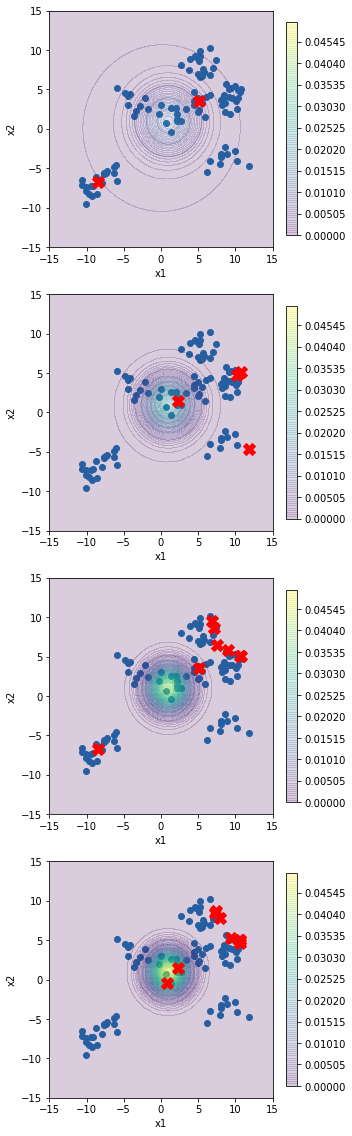

In [6]:
#Código Para Plotagem

klist = [2,4,8,10]
n = len(klist)
fig, axes = plt.subplots(n,figsize=(5,20))
i = 0

x1_test, x2_test = np.meshgrid(np.linspace(-15, 15, 50), np.linspace(-15, 15, 50))

x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

for ax in axes:
    ax.scatter(df["x1"],df["x2"])
    
    K = klist[i]
       
            
    r = algoritmoEM(X=X, K=K)
    i += 1
    
    r_test = algoritmoEM(X=x_test, K=K)
    
    pdf = expectation(x_test, K, r_test)
    
    ax.contour(x1_test, x2_test, pdf.reshape(50, 50), np.linspace(0, 0.05, 15), alpha=0.2)
    fig.colorbar(ax.contourf(x1_test, x2_test, pdf.reshape(50, 50), np.linspace(0, 0.05, 100), alpha=0.2), ax=ax, shrink=0.9)
    
      
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    
    for k in range(K):
        ax.plot(r["x_k"][k,0],r["x_k"][k,1], 'rX', markersize=12)

fig.savefig("EM_MAP")        
